## League of Legends Game Outcome Classifier

Objective: Load and clean League of Legends game data to identify important 
    game features that contribute and predict game outcome. This is important 
    because the goal of many players is to identify aspects of the game to improve
    on and the analyses outlined below is generalizable to all skill-based games
    and sports.
    
Data from: https://github.com/DoransLab/data/tree/master/champion_clustering

Python Notebook can be visualized here: https://nbviewer.jupyter.org/github/CharlesFrohlichlab/DIChallenge/blob/master/League_Classifier.ipynb

Author: Zhe Charles Zhou


In [2]:
#### Import toolboxes

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [4]:

#### Load data

data=pd.read_csv("C:\\Users\\Zhe\\Documents\\DataScienceProjects\\totalSup.csv")


#### Data Cleaning:

Let's clean up the data and split into feature (independent) and outcome (dependent) variables. Since there are many feature variables, to prevent overfitting, we will a piori select a group of variables that would likely contribute to determining win/loss (outcome variable).

In [5]:
# make the column names reference-friendly
data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_')
print(data.columns)

Index(['true_role', 'champion_name', 'participant_id', 'match_id',
       'match_rank_score', 'account_id', 'champion_id', 'win',
       'companion_score', 'split_score', 'rotation_score', 'gold_earned',
       'kills', 'deaths', 'assists', 'total_minions_killed',
       'neutral_minions_killed', 'neutral_minions_killed_team_jungle',
       'neutral_minions_killed_enemy_jungle', 'wards_placed', 'wards_killed',
       'damage_self_mitigated', 'total_damage_taken',
       'damage_dealt_to_objectives', 'damage_dealt_to_turrets',
       'magic_damage_dealt_to_champions', 'physical_damage_dealt_to_champions',
       'true_damage_dealt_do_dhampions', 'total_heal', 'time_ccing_others',
       'percent_taken', 'total_damage_dealt_to_champions', 'percent_magic',
       'kda', 'max_time'],
      dtype='object')


In [6]:
# separate outcome (dependent variable) and feature data (independent variables)
dataX_all=data.drop('win',axis=1)
dataY=data['win']

# define columns to analyze
columns2Keep = ['champion_name','match_rank_score','companion_score','gold_earned','wards_placed','damage_dealt_to_objectives','damage_dealt_to_turrets','kda','total_damage_dealt_to_champions']
dataX = dataX_all[columns2Keep]

#### Logistic regression Data Preprocessing

Our first preprocessing step is to map the categorical variable to binary values using one-hot-encoding and to scale the continuous data. These two components need to be performed separately, then the resulting data are concatenated.

Finally, we will need to split the data up into training and test sets. The training set will be used to build our logistic regression model and the test set will be used to evaluate the generalizability and accuracy of our model.

In [7]:
# Define which columns should be encoded vs scaled
columns_to_encode = ['champion_name']
columns_to_scale  = ['match_rank_score','companion_score','gold_earned','wards_placed','damage_dealt_to_objectives','damage_dealt_to_turrets','kda','total_damage_dealt_to_champions']

# Instantiate encoder/scaler
scaler = StandardScaler()
ohe    = OneHotEncoder(sparse=False)

# Scale and Encode Separate Columns
scaled_columns  = scaler.fit_transform(dataX[columns_to_scale]) 
encoded_columns =    ohe.fit_transform(dataX[columns_to_encode])

# Concatenate (Column-Bind) Processed Columns Back Together
processedX = np.concatenate([scaled_columns, encoded_columns], axis=1)


In [8]:
# from scikitlearn: split data into test and training sets
xTrain,xTest,yTrain,yTest=train_test_split(processedX,dataY,test_size=0.2,random_state=42)


#### Build the Logistic regression

GridSearchCV allows us to define a set of parameters to test. The function iteratively evaluates each parameter combination and will choose the best model parameters.

In [9]:
parameters=[
{
    'penalty':['l1','l2'],
    'C':[0.1,0.4,0.5,1],
    'random_state':[0]
    },
]

logOptimal = GridSearchCV(LogisticRegression(), parameters, scoring='accuracy')
logOptimal.fit(xTrain, yTrain)
print('Best parameters set:')
print(logOptimal.best_params_)

Best parameters set:
{'C': 1, 'penalty': 'l1', 'random_state': 0}


In [11]:
# get predictions from our model and assess the accuracy

pred = logOptimal.predict(xTest)

from sklearn.metrics import accuracy_score
print('Optimized logistic regression performance: ',
      round(accuracy_score(yTest,pred),5)*100,'%')

Optimized logistic regression performance:  83.11500000000001 %


#### Examine contribution of variables to win

We can pull out coefficients for each independent variable. Because we scaled all the independent variables in a previous step, we can compare the relative values of the coefficients. Higher coefficients indicate stronger influence.

Text(0.5, 1.0, 'Log Reg Coef Scores')

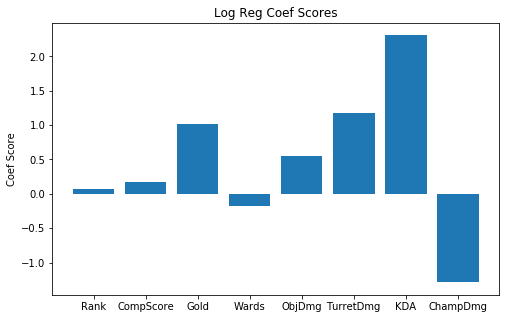

In [12]:
# use the best parameters from the last step
bestLR=LogisticRegression(C=1,penalty='l1',random_state=0)
bestLR.fit(xTrain, yTrain)

logCoefs = bestLR.coef_ # grab the coefficients from the regression

x_labels = ['Rank','CompScore','Gold','Wards','ObjDmg','TurretDmg','KDA','ChampDmg']

plt.figure(figsize=(8,5))
plt.bar(columns_to_scale[0:8],logCoefs[0,0:8])
plt.ylabel('Coef Score')
plt.xticks(np.arange(8), x_labels)
plt.title('Log Reg Coef Scores')

Figure 1. Coefficient scores for each independent variable of the fitted logistic regression. Higher values indicate stronger contribution to game outcome. We see here that gold, objective damage, turret damage, and KDA (kill-death-assist ratio) have heavy influence to game outcome. This is expected as League of Legends is at its core a strategy game.

#### Evaluate the model performance 

We will evaluate the model performance by plotting the receiver operating characteristic (ROC) curve and calculating the area under the curve (AUC).

In [13]:
# calculate predicted probability
prob = logOptimal.predict_proba(xTest)[:,1]
# calculate true and false pos 
falsePos,truePos,thresh = roc_curve(yTest,prob)
#Calculate area under the curve
AUCscore = roc_auc_score(yTest,prob)

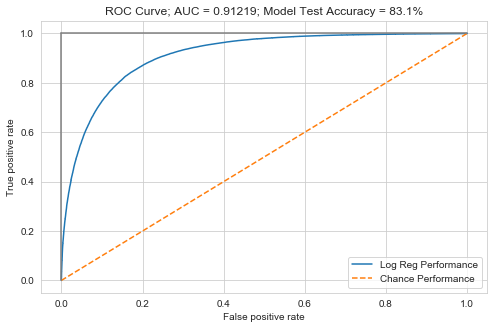

In [17]:
# ROC plot
sns.set_style('whitegrid')
plt.figure(figsize=(8,5))

plt.plot(falsePos,truePos, label="Log Reg Performance")
plt.plot([0,1],ls='--', label="Chance Performance")
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')

plt.title('ROC Curve; AUC = ' + str(round(AUCscore,5)) + '; Model Test Accuracy = ' + str(round(accuracy_score(yTest,pred),3)*100) + '%')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

Figure 2. Receiver operating characteristic (ROC) curve of the logistic regression. An ROC curve plots the sensitivity (true positive rate) as a function of specificity (1 - false positive rate). When the model performance (blue line) is close to the orange dotted line, the model has poor predictive power of game outcome; whereas if model performance reaches close to 1 and 0, respectively for true positive and false positive rates, the model has high predictive power. Here, we see that my trained logistic regression has decent predictive power with an area under the curve (AUC) of 0.912 and accuracy when predicting a test dataset of 83%.